In [36]:
from tests.auth_utils import get_toolkit_client

In [6]:
import time
from dataclasses import dataclass

from cognite.client.data_classes import FileMetadataList, FileMetadataWrite
from cognite.client.data_classes.data_modeling import NodeId, SpaceApply
from cognite.client.data_classes.data_modeling.cdm.v1 import CogniteFileApply

from cognite_toolkit._cdf_tk.client.data_classes.pending_instances_ids import PendingInstanceId

In [2]:
client = get_toolkit_client("dev-cluster.env", enable_set_pending_ids=True)

Found dev-cluster.env file in repository root. Loaded variables from dev-cluster.env file.


In [43]:
N = [1, 10, 100, 1_000, 10_000, 30_000, 100_000, 300_000]

In [3]:
@dataclass
class Execution:
    n: int
    create_file: float | None = None
    set_pending_ids: float | None = None
    create_cognite_file: float | None = None
    updated_file: float | None = None

In [45]:
# Reset for running multiple times
delete_count = 0
for existing in client.files(external_id_prefix="file_qa_load_testing", chunk_size=1000):
    delete_count += len(existing)
    instance_ids = [ts.instance_id for ts in existing if ts.instance_id is not None]
    if instance_ids:
        client.data_modeling.instances.delete_fast(instance_ids)
    ids = [ts.id for ts in existing if ts.instance_id is None]
    if ids:
        client.files.delete(id=ids)
    print(f"\rProgress: {delete_count:,}", end="", flush=True)
print(f"Deleted {delete_count:,} existing files with prefix 'file_qa_load_testing'", end="", flush=True)

Deleted 0 existing time series with prefix 'ts_qa_load_testing'

In [46]:
execution_times: list[Execution] = []
for n in N:
    execution = Execution(n=n)
    space = f"sp_upgrade_{n}"
    files = [
        FileMetadataWrite(
            external_id=f"file_qa_load_testing_{n}_{i}",
            name=f"QA Load Testing {n} {i}",
        )
        for i in range(n)
    ]

    t0 = time.perf_counter()
    created = FileMetadataList([])
    for file in files:
        created_file = client.files.upload_bytes(b"Dummy content", **file.dump(camel_case=False))
        created.append(created_file)
    elapsed = time.perf_counter() - t0
    execution.create_file = elapsed
    print(f"Created {len(created)} file for n={n} in {elapsed:.2f} seconds")
    client.data_modeling.spaces.apply(SpaceApply(space))

    t0 = time.perf_counter()
    set_pending = client.files.set_pending_ids(
        [PendingInstanceId(NodeId(space, file.external_id), external_id=file.external_id) for file in files]
    )
    elapsed = time.perf_counter() - t0
    execution.set_pending_ids = elapsed
    print(f"Set pending ids for {len(set_pending)} time series for n={n} in {elapsed:.2f} seconds")

    cognite_file = [
        CogniteFileApply(
            space=space,
            external_id=file.external_id,
            name=file.name,
        )
        for file in files
    ]
    t0 = time.perf_counter()
    created_dm = client.data_modeling.instances.apply_fast(cognite_file).nodes
    elapsed = time.perf_counter() - t0
    execution.create_cognite_file = elapsed

    print(f"Created {len(created_dm)} CogniteFiles for n={n} in {elapsed:.2f} seconds")

    updated_count = 0
    t0 = time.perf_counter()
    not_updated = created.as_ids()
    while updated_count < len(created):
        updated = client.files.retrieve_multiple(not_updated)
        not_updated = [ts.id for ts in updated if ts.instance_id is None]
        updated_count = len(created) - len(not_updated)
        print(f"Updated {updated_count} files for n={n}")
        if not not_updated:
            break
        time.sleep(0.5)
    elapsed = time.perf_counter() - t0
    execution.updated_file = elapsed
    print(f"Total time for n={n}: {elapsed:.2f} seconds")
    execution_times.append(execution)
    print("--" * 20)

Created 1 time series for n=1 in 0.13 seconds
Set pending ids for 1 time series for n=1 in 0.15 seconds
Created 1 Cognite time series for n=1 in 0.36 seconds
Updated 0 time series for n=1
Updated 1 time series for n=1
Total time for n=1: 0.66 seconds
----------------------------------------
Created 10 time series for n=10 in 0.09 seconds
Set pending ids for 10 time series for n=10 in 0.14 seconds
Created 10 Cognite time series for n=10 in 0.15 seconds
Updated 0 time series for n=10
Updated 10 time series for n=10
Total time for n=10: 0.64 seconds
----------------------------------------
Created 100 time series for n=100 in 0.10 seconds
Set pending ids for 100 time series for n=100 in 0.18 seconds
Created 100 Cognite time series for n=100 in 0.38 seconds
Updated 0 time series for n=100
Updated 100 time series for n=100
Total time for n=100: 0.66 seconds
----------------------------------------
Created 1000 time series for n=1000 in 0.29 seconds
Set pending ids for 1000 time series for n

In [56]:
updated.to_pandas()

,external_id,instance_id,name,is_string,metadata,is_step,security_categories,id,created_time,last_updated_time,pending_instance_id
0,ts_qa_load_testing_300000_0,"{'space': 'sp_upgrade_300000', 'external_id': ...",QA Load Testing 300000 0,False,{},False,[],1650180297116060,2025-06-03 09:35:07.145,2025-06-03 09:41:47.136,"{'space': 'sp_upgrade_300000', 'external_id': ..."
1,ts_qa_load_testing_300000_1,"{'space': 'sp_upgrade_300000', 'external_id': ...",QA Load Testing 300000 1,False,{},False,[],7904894262396930,2025-06-03 09:35:07.145,2025-06-03 09:41:47.142,"{'space': 'sp_upgrade_300000', 'external_id': ..."
2,ts_qa_load_testing_300000_2,"{'space': 'sp_upgrade_300000', 'external_id': ...",QA Load Testing 300000 2,False,{},False,[],5174454630713927,2025-06-03 09:35:07.145,2025-06-03 09:41:47.116,"{'space': 'sp_upgrade_300000', 'external_id': ..."
3,ts_qa_load_testing_300000_3,"{'space': 'sp_upgrade_300000', 'external_id': ...",QA Load Testing 300000 3,False,{},False,[],1465583241447642,2025-06-03 09:35:07.145,2025-06-03 09:41:47.173,"{'space': 'sp_upgrade_300000', 'external_id': ..."
4,ts_qa_load_testing_300000_4,"{'space': 'sp_upgrade_300000', 'external_id': ...",QA Load Testing 300000 4,False,{},False,[],3326123774411712,2025-06-03 09:35:07.145,2025-06-03 09:41:47.174,"{'space': 'sp_upgrade_300000', 'external_id': ..."
...,...,...,...,...,...,...,...,...,...,...,...
299995,ts_qa_load_testing_300000_299995,"{'space': 'sp_upgrade_300000', 'external_id': ...",QA Load Testing 300000 299995,False,{},False,[],1077871427668279,2025-06-03 09:39:32.124,2025-06-03 09:53:04.549,"{'space': 'sp_upgrade_300000', 'external_id': ..."
299996,ts_qa_load_testing_300000_299996,"{'space': 'sp_upgrade_300000', 'external_id': ...",QA Load Testing 300000 299996,False,{},False,[],3730971619721298,2025-06-03 09:39:32.124,2025-06-03 09:53:04.459,"{'space': 'sp_upgrade_300000', 'external_id': ..."
299997,ts_qa_load_testing_300000_299997,"{'space': 'sp_upgrade_300000', 'external_id': ...",QA Load Testing 300000 299997,False,{},False,[],8964948890205164,2025-06-03 09:39:32.124,2025-06-03 09:53:04.455,"{'space': 'sp_upgrade_300000', 'external_id': ..."
299998,ts_qa_load_testing_300000_299998,"{'space': 'sp_upgrade_300000', 'external_id': ...",QA Load Testing 300000 299998,False,{},False,[],4987915672957519,2025-06-03 09:39:32.124,2025-06-03 09:53:04.460,"{'space': 'sp_upgrade_300000', 'external_id': ..."


In [47]:
import matplotlib.pyplot as plt

In [48]:
x = [e.n for e in execution_times]
y0 = [e.create_file for e in execution_times]
y1 = [e.updated_file for e in execution_times]
y2 = [e.set_pending_ids for e in execution_times]
y3 = [e.create_cognite_file for e in execution_times]

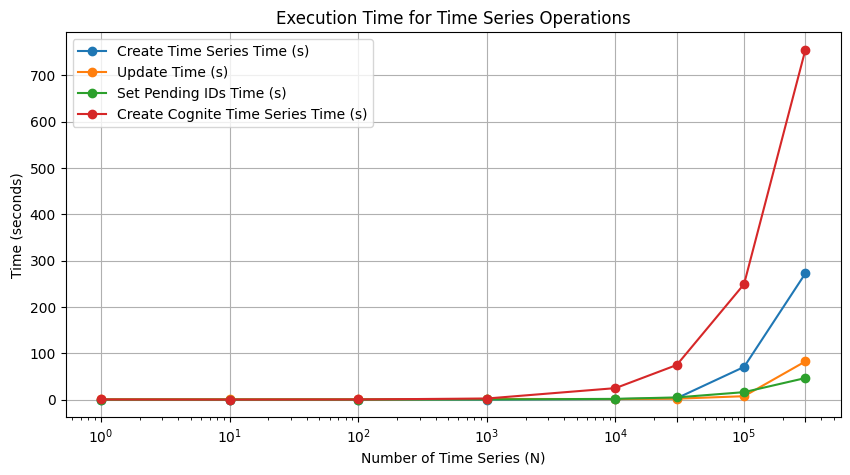

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(x, y0, marker="o", label="Create Time Series Time (s)")
plt.plot(x, y1, marker="o", label="Update Time (s)")
plt.plot(x, y2, marker="o", label="Set Pending IDs Time (s)")
plt.plot(x, y3, marker="o", label="Create Cognite Time Series Time (s)")
plt.xscale("log")
plt.xlabel("Number of Time Series (N)")
plt.ylabel("Time (seconds)")
plt.title("Execution Time for Time Series Operations")
plt.xticks(x)
plt.grid(True)
plt.legend();

In [50]:
from dataclasses import asdict

In [51]:
import pandas as pd

In [52]:
df = pd.DataFrame([asdict(e) for e in execution_times])

In [54]:
df.to_csv("qa_load_testing_results_files.csv", index=False)